### Install Requirements

In [1]:
!pip install pyarrow==15.0.2
!pip install ftfy==6.2.0
!pip install tensorboard==2.14.0
!pip install datasets==2.18.0
!pip install jupyterlab==4.1.6
!pip install transparent-background==1.2.12

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.14.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━

In [2]:
!pip install moviepy==1.0.2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 11.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transparent-background 1.2.12 requires opencv-python>=4.6.0.66, but you have opencv-python 4.5.5.64 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!sudo apt-get update -y
!sudo apt-get install -y libgl1-mesa-glx

/bin/bash: sudo: command not found
/bin/bash: sudo: command not found


In [5]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [8]:
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
import sys
sys.path.append('/root/modeling/sd/erase_back')  

from mask_model import StableDiffusionControlNetInpaintPipeline


from transformers import AutoTokenizer, PretrainedConfig
import torch

from diffusers import DiffusionPipeline
model_id = "yahoo-inc/photo-background-generation"
pipeline = DiffusionPipeline.from_pretrained(model_id, custom_pipeline=model_id)
pipeline = pipeline.to('cuda')

import sys
sys.path.append('/root/modeling/sd/erase_back')  
controlnet = ControlNetModel.from_pretrained('./controlNet')
def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")

        
tokenizer = AutoTokenizer.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        subfolder="tokenizer",
        use_fast=False,
    )

sd_inpainting_model_name = "stabilityai/stable-diffusion-2-inpainting"
# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(sd_inpainting_model_name, None)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(sd_inpainting_model_name, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    sd_inpainting_model_name, subfolder="text_encoder", revision=None
)
vae = AutoencoderKL.from_pretrained(sd_inpainting_model_name, subfolder="vae", revision=None)
unet = UNet2DConditionModel.from_pretrained(
    sd_inpainting_model_name, subfolder="unet", revision=None
)

weight_dtype = torch.float32
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    sd_inpainting_model_name,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    safety_checker=None,
    revision=None,
    torch_dtype=weight_dtype,
)
pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to('cuda')
pipeline.set_progress_bar_config(disable=True)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-22 14:55:10.555957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00, 15.91it/s]/usr/local/lib/python3.8/dist-packages/torch/storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.19it/s

### CAT Inference

In [9]:
from PIL import Image, ImageOps
import requests
from io import BytesIO

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

seed = 0

# 이미지 이름 지정
image_name = "image_9999_label_0.jpg"

# 이미지 경로를 구성
image_path = f'/root/modeling/sd/dataset/images/{image_name}'

img = Image.open(image_path)
img = resize_with_padding(img, (512, 512))

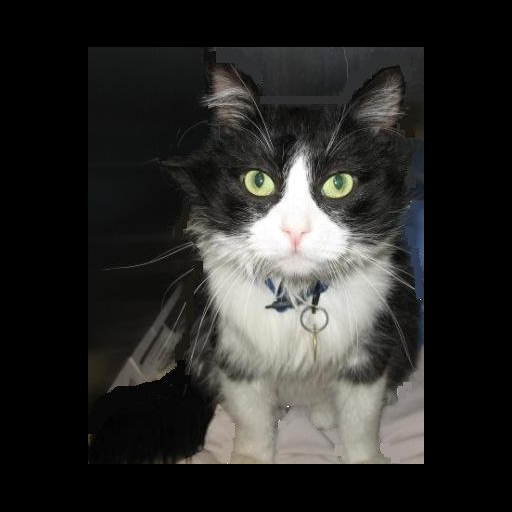

In [10]:
img

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3435.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


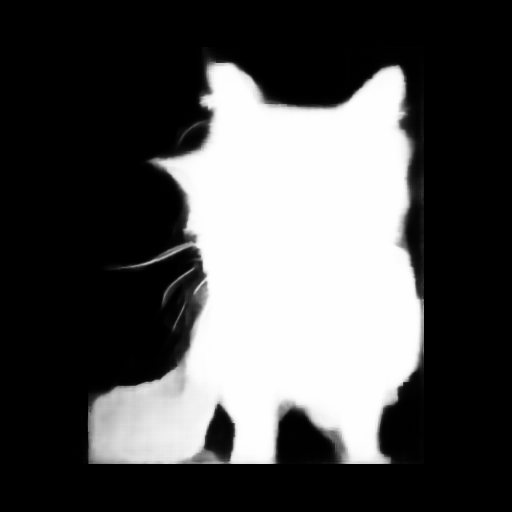

In [11]:
from transparent_background import Remover

# Load model
remover = Remover() # default setting
remover = Remover(mode='base') # nightly release checkpoint
fg_mask = remover.process(img, type='map') # default setting - transparent background
fg_mask

## Background generation using Stable Diffusion without ControlNet (cond_scale=0)

In [12]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Image saved successfully at: /root/modeling/sd/result/result_image_9999_label_0.jpg


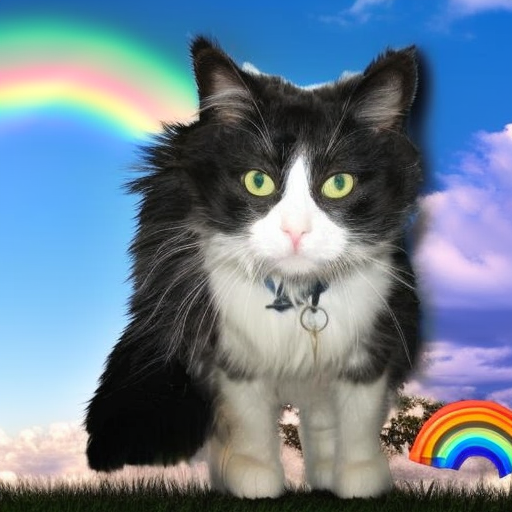

In [16]:
import os 

seed = 55
mask = ImageOps.invert(fg_mask)
img = resize_with_padding(img, (512, 512))
generator = torch.Generator(device='cuda').manual_seed(seed)
prompt = 'a cat under a clear blue sky with rainbow'
cond_scale = 0.0
with torch.autocast("cuda"):
    sd2_image = pipeline(
        prompt=prompt, image=img, mask_image=mask, control_image=mask, num_images_per_prompt=1, generator=generator, num_inference_steps=20, guess_mode=False, controlnet_conditioning_scale=cond_scale
    ).images[0]

file_path = f'/root/modeling/sd/result/result_{image_name}'

# 경로 존재 확인 및 생성
if not os.path.exists(os.path.dirname(file_path)):
    os.makedirs(os.path.dirname(file_path))

# 이미지 저장
sd2_image.save(file_path, 'JPEG')
print("Image saved successfully at:", file_path)

sd2_image

### Dog Inference

### Use Style Transfer

In [14]:
import sys 
sys.path.append('/root/modeling/sd/style_transfer/fast-style-transfer') 

In [121]:
%run /root/modeling/sd/style_transfer/fast-style-transfer/setup.sh

SyntaxError: invalid syntax (setup.sh, line 3)

In [145]:
import os
print(os.getcwd()) #현재 디렉토리 확인 및 변경

/root/modeling/sd/style_transfer/fast-style-transfer/src


In [14]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.0
    Uninstalling tensorboard-2.14.0:
      Successfully uninstalled tensorboard-2.14.0


In [17]:
import os
# 변경
os.chdir('/root/modeling/sd')

In [ ]:
%run /root/modeling/sd/style_transfer/fast-style-transfer/style.py --style style_transfer/style_image.jpg \
  --checkpoint-dir style_transfer/fast-style-transfer/checkpoint \
  --test result/result_image_9999_label_0.jpg \
  --train-path style_transfer/fast-style-transfer/data/train2014 \
  --vgg-path style_transfer/fast-style-transfer/data/imagenet-vgg-verydeep-19.mat \
  --test-dir result \
  --content-weight 1.5e1 \
  --checkpoint-iterations 1000 \
  --batch-size 20

In [ ]:
## You should know tensorflow compatible with GPU